In [1]:
MODEL_CHECKPOINT = "xlnet-base-cased"

In [2]:
import torch
from transformers import XLNetModel


class XLNetClassifier(torch.nn.Module):

    def __init__(self, model_checkpoint, dropout=0.5):

        super(XLNetClassifier, self).__init__()

        self.checkpoint = model_checkpoint
        self.xlnet = XLNetModel.from_pretrained(model_checkpoint, num_labels=2)
        self.linear1 = torch.nn.Linear(self.xlnet.config.hidden_size, self.xlnet.config.hidden_size)
        self.tanh = torch.nn.Tanh()
        
        self.dropout = torch.nn.Dropout(dropout)
        self.linear2 = torch.nn.Linear(self.xlnet.config.hidden_size, 2)


    def forward(self, input_ids, attention_mask, token_type_ids):

        xlnet_output = self.xlnet(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
        summary = self.linear1(xlnet_output.last_hidden_state[:, -1])
        activation = self.tanh(summary)
        dropout_output = self.dropout(activation)
        output = self.linear2(dropout_output)
        
        return output

c:\Users\albbl\Documents\Studium\11_Semester\medtextclassification_repo\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

In [5]:
from data_preparing import get_dataloader, split_data
from data_preprocessing import xml_to_df
from global_parameters import MAX_LEN, TEST_BATCH_SIZE, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE


xml_files = ["NEJM_data.xml", "animals_data.xml"]
data_path = "../data-querying/results/"
max_size = 50

hum_df, vet_df = xml_to_df(data_path, xml_files)
train_set, val_set, test_set = split_data(hum_df, vet_df, max_size)

train_set["title_abstract"] = train_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
val_set["title_abstract"] = val_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
test_set["title_abstract"] = test_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

train_dataloader = get_dataloader(train_set.title_abstract, train_set.labels, tokenizer, TRAIN_BATCH_SIZE, MAX_LEN)
val_dataloader = get_dataloader(val_set.title_abstract, val_set.labels, tokenizer, VAL_BATCH_SIZE, MAX_LEN)
test_dataloader = get_dataloader(test_set.title_abstract, test_set.labels, tokenizer, TEST_BATCH_SIZE, MAX_LEN)

 29%|██▉       | 7844/26780 [00:00<00:00, 68579.92it/s]

Processing medical field: human_medicine
Processing medical field: veterinary_medicine


100%|██████████| 26780/26780 [00:00<00:00, 55483.77it/s]


In [6]:
from transformers import get_linear_schedule_with_warmup
import os

from global_parameters import EPOCHS, LEARNING_RATE, PATH_SAVED_MODELS
from training import train_model
from loss_fn import loss_fn


train = False

work_dir = PATH_SAVED_MODELS
model_filename = f"{MODEL_CHECKPOINT}.bin"
filenames = None if not os.path.exists(PATH_SAVED_MODELS) else os.listdir(work_dir)

if filenames and model_filename in filenames and not train:
    model = XLNetClassifier(MODEL_CHECKPOINT)
    model.load_state_dict(torch.load(work_dir + model_filename))
    model.to(device)
    print(f"{model_filename} loaded.")
else:
    print("No saved model found or forced to train.")
    
    torch.cuda.empty_cache()
    
    model = XLNetClassifier(MODEL_CHECKPOINT)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )
    
    history = train_model(model, train_dataloader, val_dataloader, TRAIN_BATCH_SIZE, loss_fn, optimizer, device, scheduler, EPOCHS)

xlnet-base-cased.bin loaded.


In [12]:
import pandas as pd
from training import plot_performance_history

if 'history' in locals() and history:
    plot_performance_history(pd.DataFrame(history))

In [14]:
from sklearn.metrics import classification_report

from global_parameters import LABELS_MAP
from predict import predict


test_preds = predict(model, test_set.title_abstract, tokenizer, device)
test_labels = [labels.index(max(labels)) for labels in test_set.labels]
preds_labels = [torch.argmax(pred).item() for pred in test_preds]
report = classification_report(test_labels, preds_labels, target_names=LABELS_MAP.keys())
print(report)

  0%|          | 0/10 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


c:\Users\albbl\Documents\Studium\11_Semester\medtextclassification_repo\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


                     precision    recall  f1-score   support

     human_medicine       1.00      0.80      0.89         5
veterinary_medicine       0.83      1.00      0.91         5

           accuracy                           0.90        10
          macro avg       0.92      0.90      0.90        10
       weighted avg       0.92      0.90      0.90        10



In [15]:
list(LABELS_MAP.keys())

['human_medicine', 'veterinary_medicine']

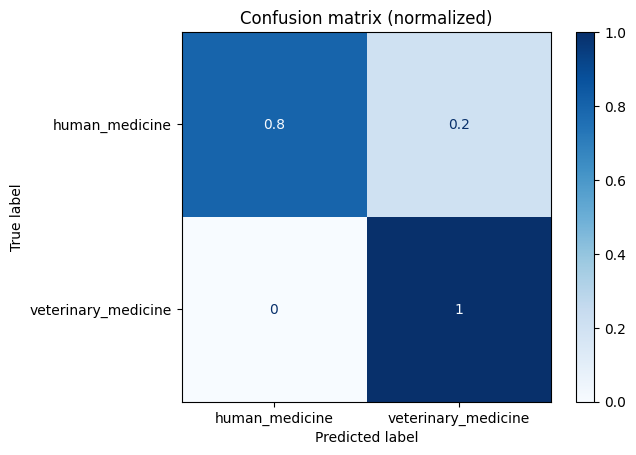

In [17]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


labels = list(LABELS_MAP.keys())
test_classes = [labels[0] if label == 0 else labels[1] for label in test_labels]
preds_classes = [labels[0] if label == 0 else labels[1] for label in preds_labels]
disp = ConfusionMatrixDisplay.from_predictions(test_classes, preds_classes, labels=labels, normalize="true", cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix (normalized)")
plt.show()